In [1]:
import pandas as pd
import numpy as np

In [2]:
print(pd.__version__)
print(np.__version__)

1.4.3
1.21.2


##### points to notice



- simple aggregation
- group by: split, apply, combine
- aggregate: filter, transform, apply
- splitting key

An essential piece of analysis of large data is efficient summarization: computing
aggregations like sum(), mean(), median(), min(), and max(), in which a single num‐
ber gives insight into the nature of a potentially large dataset. In this section, we’ll explore aggregations in Pandas, from simple operations akin to what we’ve seen on
NumPy arrays, to more sophisticated operations based on the concept of a groupby.

In [4]:
planets = pd.read_csv('../Data/seaborn/Planets.csv')
print(planets.shape)
planets.head()

(1035, 6)


,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


##### Simple Aggregation in Pandas

In [6]:
rng = np.random.RandomState(42)
df = pd.DataFrame({'A': rng.rand(5),
                          'B': rng.rand(5)})
df

,A,B
0,0.374540,0.155995
1,0.950714,0.058084
2,0.731994,0.866176
3,0.598658,0.601115
4,0.156019,0.708073


In [7]:
df.mean()

A    0.562385
B    0.477888
dtype: float64

By specifying the axis argument, you can instead aggregate within each row:

In [8]:
df.mean(axis='columns')

0    0.265267
1    0.504399
2    0.799085
3    0.599887
4    0.432046
dtype: float64

Pandas Series and DataFrames include all of the common aggregates mentioned in
“Aggregations: Min, Max, and Everything in Between”; in addition, there
is a convenience method describe() that computes several common aggregates for
each column and returns the result. Let’s use this on the Planets data, for now drop‐
ping rows with missing values:

In [9]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the year column that although exoplanets were discovered as
far back as 1989, half of all known exoplanets were not discovered until 2010 or after.
This is largely thanks to the Kepler mission, which is a space-based telescope specifi‐
cally designed for finding eclipsing planets around other stars.

These are all methods of DataFrame and Series objects. <<br>

To go deeper into the data, however, simple aggregates are often not enough. The
next level of data summarization is the groupby operation, which allows you to
quickly and efficiently compute aggregates on subsets of data.

##### GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer
to aggregate conditionally on some label or index: this is implemented in the socalled
groupby
operation. The name
“group by” comes from a command in the
SQL
database language, but it is
perhaps more
illuminative to think of it in the terms
first
coined by
Hadley
Wickham of
Rstats fame:
split,
apply,
combine.

##### Split, apply, combine

A canonical example of this split-apply-combine operation, where the “apply” is a summation aggregation,

- The split step involves breaking up and grouping a DataFrame depending on the
value of the specified key.

- The apply step involves computing some function, usually an aggregate, transfor‐
mation, or filtering, within the individual groups.

- The combine step merges the results of these operations into an output array.

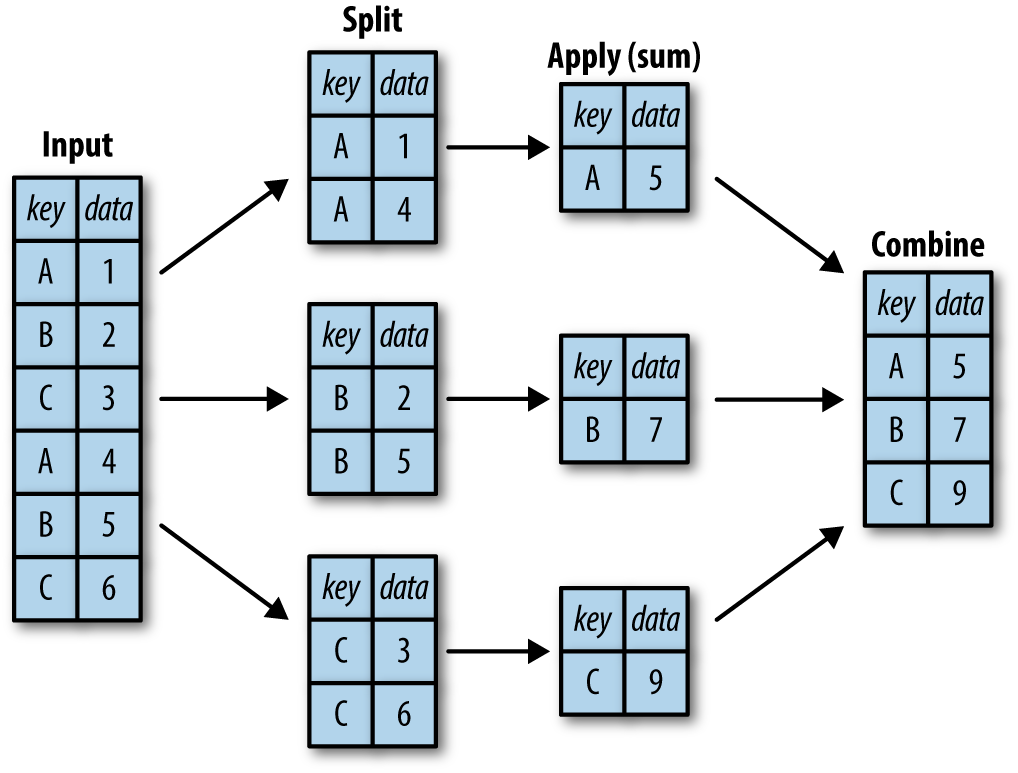

While we could certainly do this manually using some combination of the masking,
aggregation, and merging commands covered earlier, it’s important to realize that the
intermediate splits do not need to be explicitly instantiated. Rather, the GroupBy can
(often) do this in a single pass over the data, updating the sum, mean, count, min, or
other aggregate for each group along the way. The power of the GroupBy is that it
abstracts away these steps: the user need not think about how the computation is
done under the hood, but rather thinks about the operation as a whole.

As a concrete example, let’s take a look at using Pandas for the computation shown in
Figure. We’ll start by creating the input DataFrame:

In [11]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                           'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


We can compute the most basic split-apply-combine operation with the groupby()
method of DataFrames, passing the name of the desired key column:

In [12]:
df.groupby('key')

Notice that what is returned is not a set of DataFrames, but a DataFrameGroupBy
object. This object is where the magic is: you can think of it as a special view of the
DataFrame, which is poised to dig into the groups but does no actual computation
until the aggregation is applied. This “lazy evaluation” approach means that common
aggregates can be implemented very efficiently in a way that is almost transparent to
the user.

To produce a result, we can apply an aggregate to this DataFrameGroupBy object,
which will perform the appropriate apply/combine steps to produce the desired
result:

In [13]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


The sum() method is just one possibility here; you can apply virtually any common
Pandas or NumPy aggregation function, as well as virtually any valid DataFrame
operation, as we will see in the following discussion.

##### The GroupBy object

The GroupBy object is a very flexible abstraction. In many ways, you can simply treat
it as if it’s a collection of DataFrames, and it does the difficult things under the hood.
Let’s see some examples using the Planets data.

**Column indexing.** The GroupBy object supports column indexing in the same way as
the DataFrame, and returns a modified GroupBy object. For example:

In [5]:
planets.groupby('method')

In [6]:
planets.groupby('method')['orbital_period']

Here we’ve selected a particular Series group from the original DataFrame group by
reference to its column name. As with the GroupBy object, no computation is done
until we call some aggregate on the object:

In [7]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is
sensitive to.

**Iteration over groups.** The GroupBy object supports direct iteration over the groups,
returning each group as a Series or DataFrame:   

In [8]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for doing certain things manually, though it is often much faster to
use the built-in apply functionality, which we will discuss momentarily.

**Dispatch methods.**    Through some Python class magic, any method not explicitly
implemented by the GroupBy object will be passed through and called on the groups,
whether they are DataFrame or Series objects. For example, you can use the 
describe() method of DataFrames to perform a set of aggregations that describe each
group in the data:

In [9]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.0
       Eclipse Timing Variations           9.0
       Imaging                            38.0
       Microlensing                       23.0
       Orbital Brightness Modulation       3.0
                                         ...  
max    Pulsar Timing                    2011.0
       Pulsation Timing Variations      2007.0
       Radial Velocity                  2014.0
       Transit                          2014.0
       Transit Timing Variations        2014.0
Length: 80, dtype: float64

##### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but
there are more options available. In particular, GroupBy objects have aggregate(),
filter(), transform(), and apply() methods that efficiently implement a variety of
useful operations before combining the grouped data.

For the purpose of the following subsections, we’ll use this DataFrame:

In [11]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                           'data1': range(6),
                           'data2': rng.randint(0, 10, 6)},
                           columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


**Aggregation.**    We’re now familiar with GroupBy aggregations with sum(), median(),
and the like, but the aggregate() method allows for even more flexibility. It can take
a string, a function, or a list thereof, and compute all the aggregates at once. Here is a
quick example combining all these:

In [12]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another useful pattern is to pass a dictionary mapping column names to operations
to be applied on that column:

In [13]:
df.groupby('key').aggregate({'data1': 'min',
                            'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


**Filtering.**    A filtering operation allows you to drop data based on the group proper‐
ties. For example, we might want to keep all groups in which the standard deviation is
larger than some critical value:

In [14]:
def filter_func(x):
    return x['data2'].std() > 4

print(df); print(df.groupby('key').std());
print(df.groupby('key').filter(filter_func))

  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9


The filter() function should return a Boolean value specifying whether the group
passes the filtering. Here because group A does not have a standard deviation greater
than 4, it is dropped from the result.

**Transformation.**    While aggregation must return a reduced version of the data, trans‐
formation can return some transformed version of the full data to recombine. For
such a transformation, the output is the same shape as the input. A common example
is to center the data by subtracting the group-wise mean:

In [15]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


**The apply() method.**   The apply() method lets you apply an arbitrary function to the
group results. The function should take a DataFrame, and return either a Pandas
object (e.g., DataFrame, Series) or a scalar; the combine operation will be tailored to
the type of output returned.

For example, here is an apply() that normalizes the first column by the sum of the
second:

In [16]:
 def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x
print(df); print(df.groupby('key').apply(norm_by_data2))

  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9
  key     data1  data2
0   A  0.000000      5
1   B  0.142857      0
2   C  0.166667      3
3   A  0.375000      3
4   B  0.571429      7
5   C  0.416667      9


apply() within a GroupBy is quite flexible: the only criterion is that the function takes
a DataFrame and returns a Pandas object or scalar; what you do in the middle is up to
you!

##### Specifying the split key

In the simple examples presented before, we split the DataFrame on a single column
name. This is just one of many options by which the groups can be defined, and we’ll
go through some other options for group specification here.

**A list, array, series, or index providing the grouping keys.**    The key can be any series or list
with a length matching that of the DataFrame. For example:

In [17]:
 L = [0, 1, 0, 1, 2, 0]
print(df); print(df.groupby(L).sum())

  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9
   data1  data2
0      7     17
1      4      3
2      4      7


Of course, this means there’s another, more verbose way of accomplishing the
df.groupby('key') from before:

In [18]:
print(df); print(df.groupby(df['key']).sum())

  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9
     data1  data2
key              
A        3      8
B        5      7
C        7     12


##### Grouping example

As an example of this, in a couple lines of Python code we can put all these together
and count discovered planets by method and by decade:

In [19]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0
